In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import lmfit
from lmfit.models import LinearModel, LorentzianModel
from uncertainties import unumpy as up
from uncertainties import ufloat
from uncertainties import wrap
from pathlib import Path

In [2]:
def voigt1(x,s1,g1,o1,scale1):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)#+a*x**2+b
def voigt2(x,s1,s2,g1,g2,o1,o2,scale1,scale2):
    return scale1*scipy.special.voigt_profile(x-o1,s1,g1)+scale2*scipy.special.voigt_profile(x-o2,s2,g2)#+a*x**2+b

In [3]:
def FWHM(s_p,g_p):
    s = ufloat(s_p.value,s_p.stderr)
    g = ufloat(g_p.value,g_p.stderr)
    fg=s*(8*up.log(2))**0.5
    fl=2*g
    return 0.5346*fl+((fg)**2+(0.2166*fl**2))**0.5

def uvoigt1(out_voigt):
    x_p,s1_p,g1_p,o1_p,scale1_p=out_voigt.result.params['o1'],out_voigt.result.params['s1'],out_voigt.result.params['g1'],out_voigt.result.params['o1'],out_voigt.result.params['scale1']
    x = ufloat(x_p.value,x_p.stderr)
    s1 = ufloat(s1_p.value,s1_p.stderr)
    g1 = ufloat(g1_p.value,g1_p.stderr)
    o1 = ufloat(o1_p.value,o1_p.stderr)
    scale1 = ufloat(scale1_p.value,scale1_p.stderr)
    uv=wrap(voigt1)
    return uv(x,s1,g1,o1,scale1)

def uvoigt2(out_voigt):
    x1_p,s1_p,g1_p,o1_p,scale1_p=out_voigt.result.params['o1'],out_voigt.result.params['s1'],out_voigt.result.params['g1'],out_voigt.result.params['o1'],out_voigt.result.params['scale1']
    x2_p,s2_p,g2_p,o2_p,scale2_p=out_voigt.result.params['o2'],out_voigt.result.params['s2'],out_voigt.result.params['g2'],out_voigt.result.params['o2'],out_voigt.result.params['scale2']
    x1 = ufloat(x1_p.value,x1_p.stderr)
    s1 = ufloat(s1_p.value,s1_p.stderr)
    g1 = ufloat(g1_p.value,g1_p.stderr)
    o1 = ufloat(o1_p.value,o1_p.stderr)
    scale1 = ufloat(scale1_p.value,scale1_p.stderr)
    x2 = ufloat(x2_p.value,x2_p.stderr)
    s2 = ufloat(s2_p.value,s2_p.stderr)
    g2 = ufloat(g2_p.value,g2_p.stderr)
    o2 = ufloat(o2_p.value,o2_p.stderr)
    scale2 = ufloat(scale2_p.value,scale2_p.stderr)


    uv=wrap(voigt2)

    p1 = uv(x1,s1,s2,g1,g2,o1,o2,scale1,scale2)
    p2 = uv(x2,s1,s2,g1,g2,o1,o2,scale1,scale2)
    return p1,p2

def uvoigt(out_voigt):
    try:
        return uvoigt2(out_voigt)
    except:
        return uvoigt1(out_voigt)

In [4]:
res = Path("results_220/voigt_fits_220_40_40.txt")
res.touch()
nf = open(res,"w")
nf.write("Amplitude1\tAmplitude2\tmu1\tmu2\tsigma1\tsigma2\tgamma1\tgamma2\tFWHM1\tFWHM2\tHeight1\tHeight2\tredchi\n")

def bwrite(fr,fwhm1,height1):
    nf.write(
                str(fr.params['scale1'].value)+"\t"+str(fr.params['scale1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['o1'].value)+"\t"+str(fr.params['o1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['s1'].value)+"\t"+str(fr.params['s1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.params['g1'].value)+"\t"+str(fr.params['g1'].stderr)+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fwhm1[0])+"\t"+str(fwhm1[1])+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(height1[0])+"\t"+str(height1[1])+"\t"+
                "none"+"\t"+"none"+"\t"+
                str(fr.redchi)+"\n"
                )
        

def awrite(fr,fwhm1,height1,fwhm2,height2):
    nf.write(
                str(fr.params['scale1'].value)+"\t"+str(fr.params['scale1'].stderr)+"\t"+
                str(fr.params['scale2'].value)+"\t"+str(fr.params['scale2'].stderr)+"\t"+                
                str(fr.params['o1'].value)+"\t"+str(fr.params['o1'].stderr)+"\t"+
                str(fr.params['o2'].value)+"\t"+str(fr.params['o2'].stderr)+"\t"+                
                str(fr.params['s1'].value)+"\t"+str(fr.params['s1'].stderr)+"\t"+
                str(fr.params['s2'].value)+"\t"+str(fr.params['s2'].stderr)+"\t"+                
                str(fr.params['g1'].value)+"\t"+str(fr.params['g1'].stderr)+"\t"+
                str(fr.params['g2'].value)+"\t"+str(fr.params['g2'].stderr)+"\t"+                
                str(fwhm1[0])+"\t"+str(fwhm1[1])+"\t"+
                str(fwhm2[0])+"\t"+str(fwhm2[1])+"\t"+                
                str(height1[0])+"\t"+str(height1[1])+"\t"+
                str(height2[0])+"\t"+str(height2[1])+"\t"+                
                str(fr.redchi)+"\n"
                )
       

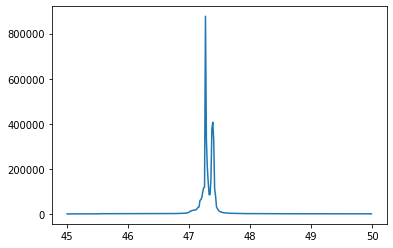

In [5]:
path =  'Data/Si220_40kV_40mA.xy'
with open(path) as tf:
    data = np.loadtxt(tf,delimiter=" ").T

err = np.zeros(len(data[1]))
for i in range(len(err)):
    err[i] = (data[1,i])**0.5
data = np.vstack([data,err])
plt.plot(data[0],data[1])

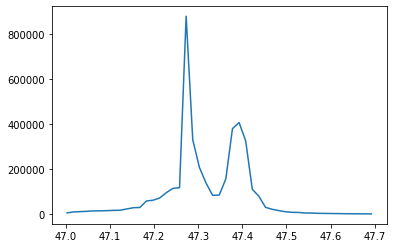

In [6]:
x=[[],[]]
for i in range(len(data[1])):
    if 47<data[0,i]<47.7:
        x[0].append(data[0,i])
        x[1].append(data[1,i])
plt.plot(x[0],x[1])

In [7]:
for i in range(len(data[0])):
    if data[0,i]>=47.7:
        print(i)
        break

180


In [8]:
#modell erstellen a1 = [47,47.7]->[133,180]    
model_voigt = lmfit.model.Model(voigt2)  

#parameter erstellen
pars_voigt = model_voigt.make_params()

#Parameter Optimieren
pars_voigt["s1"].set(value=0.0137,min=0.005,max=1)
pars_voigt["g1"].set(value=0.0137,min=0,max=1)
pars_voigt["s2"].set(value=0.0147,min=0,max=1)
pars_voigt["g2"].set(value=0.0147,min=0,max=1)
pars_voigt["o1"].set(value=47.25,min=47.2,max=47.35)
pars_voigt["o2"].set(value=47.4,min=47.35,max=47.5)
pars_voigt["scale1"].set(25000)
pars_voigt["scale2"].set(15000)
 
#Fitten
out_voigt = model_voigt.fit(data[1,133:180],x=data[0,133:180],params=pars_voigt,weights=1/data[2,133:180],nan_policy='propagate')
a1f=out_voigt.fit_report()
a1p=np.array([np.arange(47,47.7,0.001),out_voigt.eval(x=np.arange(47,47.7,0.001))])


h1 = uvoigt(out_voigt)[0].format(":1.5").split("+/-")
h2 = uvoigt(out_voigt)[1].format(":1.5").split("+/-")

fwhm1=FWHM(out_voigt.result.params['s1'],out_voigt.result.params['g1']).format(":1.5").split("+/-")
fwhm2=FWHM(out_voigt.result.params['s2'],out_voigt.result.params['g2']).format(":1.5").split("+/-")

awrite(out_voigt,fwhm1,h1,fwhm2,h2)

nf.close()


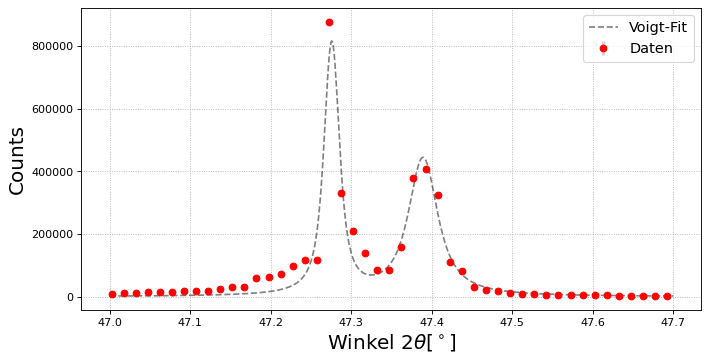

In [9]:
fig = plt.figure(figsize=(10,5),dpi=80,linewidth=50)
plt.grid(axis='both',linestyle=':')
plt.errorbar(data[0,133:180],data[1,133:180],yerr=data[2,133:180],fmt='o',ecolor='lightgray',color='r', elinewidth=3, capsize=0,zorder=10,label="Daten")
plt.plot(a1p[0],a1p[1],zorder=10,color='k',linestyle='--',alpha=0.5,label="Voigt-Fit")
plt.ylabel("Counts",size=18)
plt.xlabel("Winkel 2"r"$\theta$"r'[$^\circ$]',size=18)
plt.legend(fontsize=13)
plt.savefig('results_220/a1.pdf')

In [10]:
print(a1f)

[[Model]]
    Model(voigt2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 588
    # data points      = 47
    # variables        = 8
    chi-square         = 494747.597
    reduced chi-square = 12685.8358
    Akaike info crit   = 451.297804
    Bayesian info crit = 466.098985
[[Variables]]
    s1:      0.00500000 +/- 0.00846960 (169.39%) (init = 0.0137)
    s2:      0.00628575 +/- 0.01017095 (161.81%) (init = 0.0147)
    g1:      0.00830679 +/- 0.00363197 (43.72%) (init = 0.0137)
    g2:      0.01926756 +/- 0.00481955 (25.01%) (init = 0.0147)
    o1:      47.2759839 +/- 0.00134837 (0.00%) (init = 47.25)
    o2:      47.3893626 +/- 0.00255226 (0.01%) (init = 47.4)
    scale1:  26184.2422 +/- 3230.06001 (12.34%) (init = 25000)
    scale2:  28997.7210 +/- 2818.77816 (9.72%) (init = 15000)
[[Correlations]] (unreported correlations are < 0.100)
    C(s1, g1)         = 0.907
    C(s2, g2)         = -0.812
    C(g1, scale1)     = 0.655
    C(s1, scale1)     = 0.